# Response Methods

## TD-DFT v $\Delta$-SCF 

## Transition dipoles

In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
tddft_results = json.load(open("tddft_data.json"))

In [11]:
directories = os.walk(".")

results = {
    "chromophore" : [],
    "dscf_energies" : [],
    "dscf_mags" : [],
    "sto_energies" : [],
    "sto_mags" : [],
    "tddft_energies" : [],
    "tddft_mags" : []
}

def extract_energy_mag(lines):
    energy = None
    mag = None
    
    for line in lines:    
        if "Excitation energy:" in line:
            energy = re.findall(r'0.\d+', line)
            energy = float(energy[0])
        if "Transition dipole" in line:
            dipole = re.findall(r'-?\d+.\d+', line)
            mag = np.linalg.norm(np.array([float(dipole[0]), float(dipole[1]), float(dipole[2])]))
    
    return (energy, mag)

for direc in directories:
    folder = direc[0]
    files = direc[2]

    dscf_file = ""
    chromophore_name = ""
    sto_file = ""
    
    for file in files:
        if re.search(r'.out', file) is not None:
            if re.match(r'dscf', file):
                dscf_file = file
                chromophore_name = file
                chromophore_name = chromophore_name.replace("dscf_", "")
                chromophore_name = chromophore_name.replace(".out", "")

            if re.match(r'sto', file):
                sto_file = file
                
    if not dscf_file:
        continue
    if chromophore_name not in list(tddft_results.keys()):
        continue
        
    dscf_energy, dscf_mag = extract_energy_mag(list(open(f"{folder}/{dscf_file}").readlines()))
    sto_energy, sto_mag = extract_energy_mag(list(open(f"{folder}/{sto_file}").readlines()))
    
    if any(i is None for i in [dscf_energy, dscf_mag, sto_energy, sto_mag]):
        continue
        
    if dscf_energy is not None and dscf_mag is not None and dscf_energy > 0.05:
        results["chromophore"].append(chromophore_name)
        results["dscf_energies"].append(dscf_energy)
        results["sto_energies"].append(sto_energy)
        results["tddft_energies"].append(tddft_results[chromophore_name]["energy"])

        results["dscf_mags"].append(dscf_mag)
        results["sto_mags"].append(sto_mag)
        results["tddft_mags"].append(np.linalg.norm(tddft_results[chromophore_name]["transition_dipole"]))


results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df

,chromophore,dscf_energies,dscf_mags,sto_energies,sto_mags,tddft_energies,tddft_mags
0,step_1051_chromophore_26,0.056584,4.392234,0.067836,4.097255,0.064942,2.737867
1,step_1301_chromophore_4,0.059866,4.325017,0.075646,4.050575,0.068846,2.906186
2,step_1251_chromophore_4,0.061092,4.244279,0.077987,3.878582,0.068925,2.667543
3,step_1051_chromophore_19,0.061808,4.148581,0.084290,3.765919,0.069957,2.634198
4,step_1251_chromophore_24,0.058298,4.398588,0.071993,4.113521,0.067101,2.796674
...,...,...,...,...,...,...,...
248,step_1201_chromophore_1,0.058409,4.343263,0.070347,3.979949,0.066780,2.763660
249,step_1851_chromophore_5,0.063576,4.094880,0.078003,3.800450,0.070217,2.600691
250,step_1201_chromophore_8,0.063443,4.261074,0.075159,3.994685,0.071017,2.676379
251,step_351_chromophore_12,0.062129,4.152538,0.069905,3.875701,0.070572,2.778542


In [12]:
results_df.corr()

,dscf_energies,dscf_mags,sto_energies,sto_mags,tddft_energies,tddft_mags
dscf_energies,1.000000,-0.528559,0.564093,-0.287975,0.908163,-0.430421
dscf_mags,-0.528559,1.000000,-0.283346,0.482214,-0.483493,0.640633
sto_energies,0.564093,-0.283346,1.000000,-0.658616,0.530694,-0.237638
sto_mags,-0.287975,0.482214,-0.658616,1.000000,-0.295916,0.355862
tddft_energies,0.908163,-0.483493,0.530694,-0.295916,1.000000,-0.295732
tddft_mags,-0.430421,0.640633,-0.237638,0.355862,-0.295732,1.000000


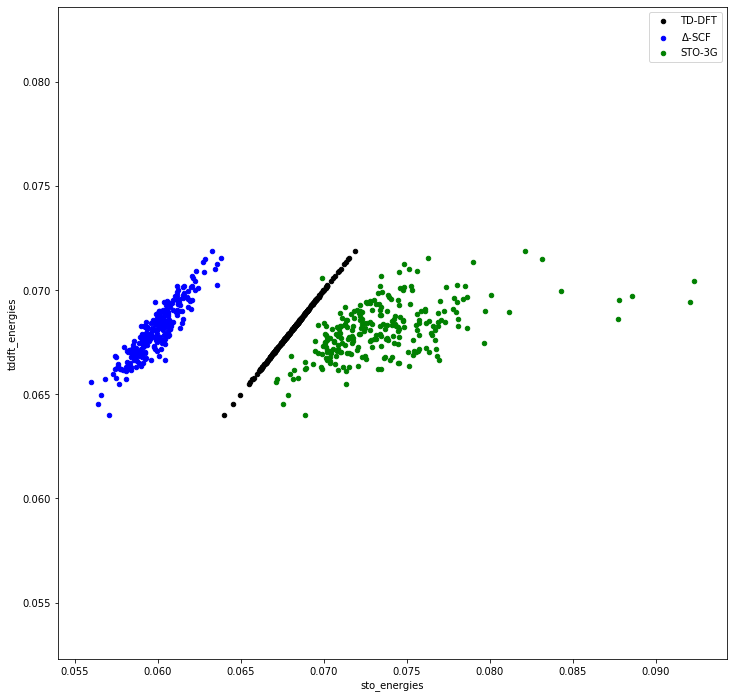

In [18]:
fig, ax = plt.subplots()
results_df.plot.scatter("tddft_energies", "tddft_energies", ax=ax, color='black', label='TD-DFT')
results_df.plot.scatter("dscf_energies", "tddft_energies", ax=ax, color='blue', label='$\Delta$-SCF')
results_df.plot.scatter("sto_energies", "tddft_energies", ax=ax, color='green', label='STO-3G')
fig.set_size_inches(12, 12)

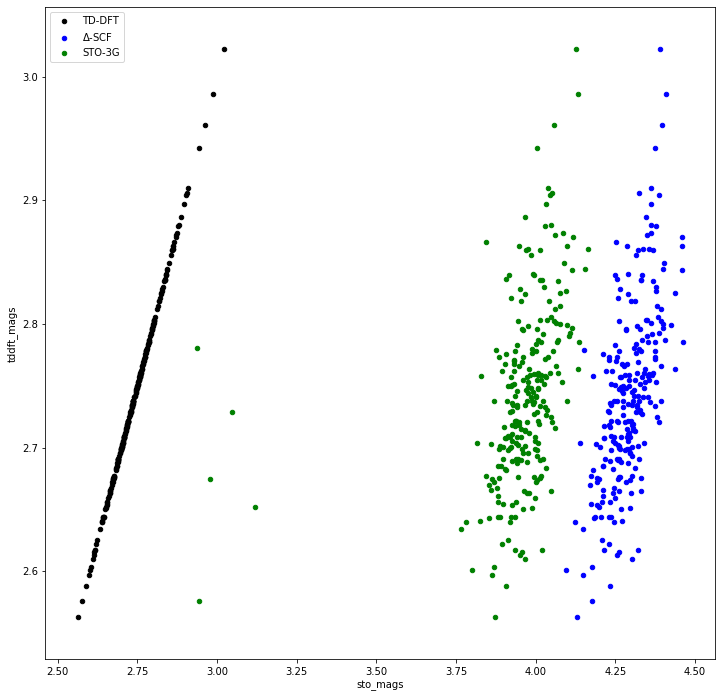

In [19]:
fig, ax = plt.subplots()
results_df.plot.scatter("tddft_mags", "tddft_mags", ax=ax, color='black', label='TD-DFT')
results_df.plot.scatter("dscf_mags", "tddft_mags", ax=ax, color='blue', label='$\Delta$-SCF')
results_df.plot.scatter("sto_mags", "tddft_mags", ax=ax, color='green', label='STO-3G')
fig.set_size_inches(12, 12)